# CS5489- Machine Learning
# Lecture 9a - Convolutional Neural Networks (CNNs)
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- Convolutional neural network (CNN)
- Regularization

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from scipy import signal

rbow = plt.get_cmap('rainbow')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten
from tensorflow.keras import backend as K
import struct
print(keras.__version__, tf.__version__)

2.4.0 2.4.1


In [3]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [4]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                plt.title(titles % idx)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()


In [5]:
def read_32int(f):
    return struct.unpack('>I', f.read(4))[0]
def read_img(img_path):
    with open(img_path, 'rb') as f:
        magic_num = read_32int(f)
        num_image = read_32int(f)
        n_row = read_32int(f)
        n_col = read_32int(f)
        #print 'num_image = {}; n_row = {}; n_col = {}'.format(num_image, n_row, n_col)
        res = []
        npixel = n_row * n_col
        res_arr = fromfile(f, dtype='B')
        res_arr = res_arr.reshape((num_image, n_row, n_col), order='C')
        #print 'image data shape = {}'.format(res_arr.shape)
        return num_image, n_row, n_col, res_arr    
def read_label(label_path):
    with open(label_path, 'rb') as f:
        magic_num = read_32int(f)
        num_label = read_32int(f)
        #print 'num_label = {}'.format(num_label)
        res_arr = fromfile(f, dtype='B')
        #print res_arr.shape
        #res_arr = res_arr.reshape((num_label, 1))
        res_arr = res_arr.ravel()
        #print 'label data shape = {}'.format(res_arr.shape)
        return num_label, res_arr

In [6]:
n_train, nrow, ncol, trainimg = read_img('data/train-images.idx3-ubyte')
_, trainY = read_label('data/train-labels.idx1-ubyte')
n_test, _, _, testimg = read_img('data/t10k-images.idx3-ubyte')
_, testY = read_label('data/t10k-labels.idx1-ubyte')

# for demonstration we only use 10% of the training data
sample_index = range(0, trainimg.shape[0], 10)
trainimg  = trainimg[sample_index]
trainY    = trainY[sample_index]
print(trainimg.shape)
print(trainY.shape)
print(testimg.shape)
print(testY.shape)

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)

(6000, 28, 28)
(6000,)
(10000, 28, 28)
(10000,)


# Signals
- So far we have assumed the input $\mathbf{x}$ is a vector
  - or have turned 2D images into vectors.
- _What if the input has more structure?_

- For example:
  - **1-D signal** (time)
  
<table><tr><th>mono audio (1 feature)</th><th>stereo audio  (2 features)</th></tr>
    <tr><td><img src="imgs/audio1.png" width=400></td><td><img src="imgs/audio2.jpg" width=400></td></tr></table>


  - **2-D signal** (space)
<table><tr><th>grayscale image (1 feature)</th><th>color image (3 features)</th><th>hyperspectral image (300 features)</th></tr>
    <tr><td><img src="imgs/ducklings-g.jpg" width=300></td><td> <img src="imgs/ducklings.jpg" width=300></td><td><img src="imgs/hyperspectral.jpg" width=300></td></tr></table>

  - **3-D signal** (space+time, volume)

<table><tr><th>color video (3 features)</th><th>3D CT scan (1 feature)</th></tr>
    <tr><td><img src="imgs/video.png" width=300></td><td><img src="imgs/ct.jpeg" width=300></td></tr></table>



# Assumed Properties of Signals
- *Locality*
  - at low-level, features from 1 region  are independent (do not depend on) features from a far-away region.
<table><tr><td><img src="imgs/audio1-boxes.png" width=300></td><td><img src="imgs/ducklings-boxes.jpg" width=300></td></tr></table>

- *Translation* 
  - the same features can appear anywhere in the signal.
  
  <table><tr><td><img src="imgs/audio1-1.png" width=300></td><td><img src="imgs/ducklings-1.jpg" width=300></td></tr><tr><td><img src="imgs/audio1-2.png" width=300></td><td><img src="imgs/ducklings-2.jpg" width=300></td></tr></table>

# Using the standard MLP layer...
- Each feature $z_i$ is computed from all the inputs, but we only want local features (locality).
- The pattern could appear anywhere, but weights are trained for each location $z_i$ separately (translation).
<center><img src="imgs/badmlp.png" width=200></center>

- For image input, we transform the image into a vector, which is the input into the MLP.
    
<center>
<table><tr>
<td><img src="imgs/ducklings.jpg" width=300></td>
<td><img src="imgs/2d1d.svg" width=200></td>
<td><img src="imgs/neural_net.jpeg" width=300></td>
</tr></table></center>

- **Problem:** This ignores the spatial relationship between pixels in the image.
  - Images contain local structures 
    - groups of neighboring pixels correspond to visual structures (edges, corners, texture).
    - pixels far from each other are typically not correlated.

- **How to model the local structure of the signal?**
  - local features, feature translation

- **Answer**: Use a local feature extractor in the signal.

# Convolution
- Consider 1D signal in *discrete* time: $x(t)$, $t \in \mathbb{Z}$
- Define the filter $w(t)$ 
  - "flipped" filter: $\tilde{w}(t) = w(-t)$  

In [7]:
def zeropad(w, left0, right0):
    return concatenate([zeros(left0,), w, zeros(right0,)])

def zeropad2(w, left0, right0, up0, down0):
    ws = w.shape;
    x = concatenate([
        zeros(shape=(up0,left0+ws[1]+right0)), 
        concatenate([
            zeros(shape=(ws[0], left0)),
            w,
            zeros(shape=(ws[0], right0))
        ], axis=1), 
        zeros(shape=(down0, left0+ws[1]+right0))
    ])
    return x

In [8]:
random.seed(4487)
x = linspace(-3,3,30) + 0.3*random.normal(size=(30,))
w = [1/3, 1/3, 1/3]
ww = zeropad(w,5,5)
tw = flip(w)

xfig = plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.stem(x, use_line_collection=True)
plt.grid(True)
plt.xlabel('t')
plt.title('x(t)')
plt.subplot(1,2,2)
plt.stem(arange(-6,7), ww, use_line_collection=True)
plt.xlabel('t')
plt.title('w(t)')
plt.grid(True)
plt.close()

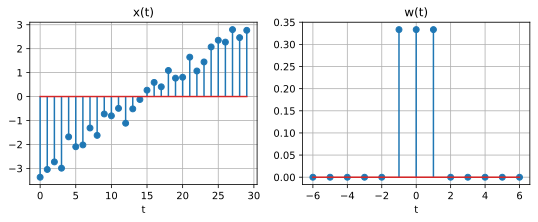

In [9]:
xfig

- Convolution is a filtering operation
  - $s(t) = x * w = \sum_a x(a) w(t-a)$
    - "$*$" is the symbol for convolution
- It's related to cross-correlation with the "flipped" filter.
  - $s(t) = \sum_a  x(a) \tilde{w}(a-t)$
  - for a given $t$:
    1. shift $\tilde{w}$ by $t$
    2. multiply shifted $\tilde{w}$ with $x$
    3. sum to get $s(t)$

In [10]:
s = convolve(x, w)

sfig = plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.stem(x, use_line_collection=True)
plt.xlim(-3,32); plt.grid(True)
plt.ylabel('$x(a)$')
plt.xlabel('a')
plt.subplot(3,1,2)
plt.stem(range(-2,1), tw, use_line_collection=True)
plt.stem(range(10,13), tw, markerfmt='or', use_line_collection=True)
plt.stem(range(20,23), tw, markerfmt='om', use_line_collection=True)
plt.stem(range(29,32), tw, markerfmt='og', use_line_collection=True)
plt.xlim(-3,32); plt.grid(True)
plt.ylabel('$\\tilde{w}(a-t)$')
plt.xlabel('a')
plt.stem(zeros(30,), markerfmt=',r', use_line_collection=True)
plt.subplot(3,1,3)
plt.stem(range(-1,31), s, use_line_collection=True)
plt.xlim(-3,32); plt.grid(True)
plt.ylabel('$s(t)$')
plt.xlabel('t')
#plt.subplots_adjust(hspace=0.35)
plt.tight_layout()
plt.close()



- $s(t) = \sum_a  x(a) \tilde{w}(a-t)$
  1. shift $\tilde{w}$ by $t$
  2. multiply shifted $\tilde{w}$ with $x$
  3. sum to get $s(t)$

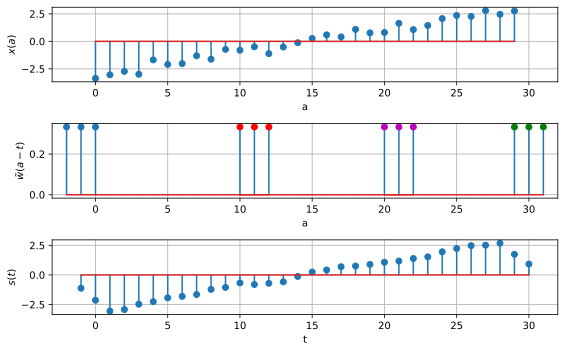

In [11]:
sfig

- Boundary conditions
  - It is assumed that the rest of the signal is all 0.
- The convolution result near the ends of the signal uses these "artificial" zeros.
  - the filtered signal is longer than the original signal
  - length  increases by $P-1$, where $P$ is the non-zero extent of the filter.


- Three ways to handle this:
  - 1) use everything with *non-zero* response ('full' mode)
  - 2) keep the response the *same* length as the signal  ('same' mode)
  - 3) keep only responses where the *entire* filter is on the signal ('valid' mode)

In [12]:
cfig = plt.figure(figsize=(8,5))
plt.subplot(4,1,1)
plt.stem(x, use_line_collection=True)
plt.xlim(-3,32); plt.grid(True)
plt.title('$x(t)$, length=30')
plt.subplot(4,1,2)
plt.stem(range(-1,31), convolve(x,w,mode='full'), use_line_collection=True)
plt.xlim(-3,32); plt.grid(True)
plt.title('$s(t)$ (full), length=32')
plt.subplot(4,1,3)
plt.stem(range(0,30), convolve(x,w,mode='same'), use_line_collection=True)
plt.xlim(-3,32); plt.grid(True)
plt.title('$s(t)$  (same), length=30')
plt.subplot(4,1,4)
plt.stem(range(1,29), convolve(x,w,mode='valid'), use_line_collection=True)
plt.xlim(-3,32); plt.grid(True)
plt.title('$s(t)$  (valid), length=28')

#plt.subplots_adjust(hspace=0.50)
plt.tight_layout()
plt.close()




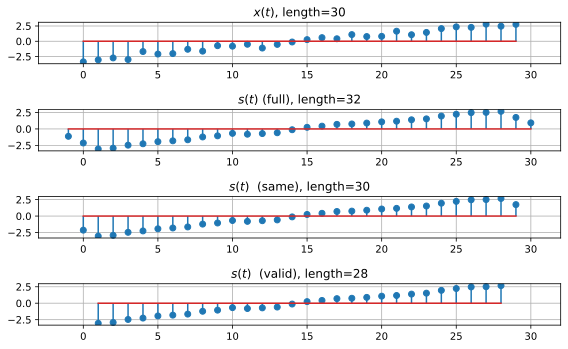

In [13]:
cfig

# 2D Convolution
- Straightforward to extend to multiple dimensions
- 2D discrete convolution
  $$s(n,m) = x*w = \sum_a \sum_b x(a,b) w(n-a, m-b)$$

In [14]:
X = trainimg[0]
W = array([[1,1,1],[1,1,1], [1,1,1]])/9.

sfig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(X, cmap='gray')
plt.title('x(n,m)')
plt.subplot(1,3,2)
plt.imshow(zeropad2(W, 5, 5, 5, 5), cmap='gray')
plt.title('w(n,m)')
plt.subplot(1,3,3)
plt.imshow(signal.convolve2d(X,W), cmap='gray')
plt.title('s(n,m)')
plt.close()

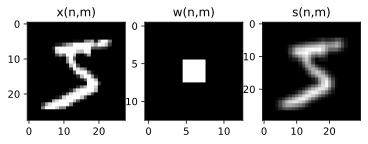

In [15]:
sfig

# Two Interpretations of Convolution
- Interpretation 1:
  - $w$ is a filter  on  the  frequency spectrum of signal $x$.
      - Example filters: *low-pass*, *high-pass*, *band-pass*, *moving-average*
<img src="imgs/filters.png" width=600>

- Analysis is in the frequency domain:
  - **Time domain**  $x(t)$ $\Longleftrightarrow$ **Frequency domain** $X(\omega)$
- Discrete-time Fourier transform (DTFT)
  - represent data as sum of complex exponentials basis functions with different frequencies.
    - $e^{-i \omega t} = \cos (\omega t) - i \sin (\omega t)$
    - Imaginary number: $i^2 = -1$
  -  $X(\omega) = \sum_t x(t) e^{-i\omega t}$ $\Longleftrightarrow$  $x(t) = \frac{1}{2\pi} \int X(\omega) e^{i\omega t}d\omega$ 


- **Key results:**
  - convolution in the time domain is equivalent to multiplication in the frequency domain:
    - $s(t) = x(t)*w(t)$ $\Longleftrightarrow$ $S(\omega) = X(\omega)W(\omega)$
  - we can design and analyze filters in the frequency domain, and then obtain their time-domain representation.

In [16]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from scipy.fftpack import fft as fft

fs = 30.0       # sample rate, Hz

# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)


tt = linspace(-10,10)
w = sin(3.*tt/2) /  (tt/2);

y = convolve(data, w, mode='same')
ffig = plt.figure(figsize=(8,4))

plt.subplot(3, 2, 1)
plt.plot(range(0,n), data, 'b-', label='data')
plt.grid()
plt.title('original data  $x$')


plt.subplot(3, 2, 5)
plt.plot(range(0,n), y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('time')
plt.title('filtered data  $s=x*w$')
plt.grid()



def calculateFFT(time,signal):
    signal = concatenate([signal, zeros((3*len(signal),))])
    N=len(signal)      
    #df=1/((time[-1]-time[0]))
    #frequencies=[i*df for i in range(int(N/2.0))]
    frequencies = linspace(0,pi,int(N/2.))
    fftValues = [2.0/N*abs(i) for i in fft(signal,N)[0:int(N/2.0)] ]
    return frequencies,fftValues

plt.subplot(3, 2, 2)
originalfreqs,originalFFT=calculateFFT(t,data)
plt.plot(originalfreqs,originalFFT,"b",label="original")
plt.grid()
plt.title('original spectrum X')

plt.subplot(3, 2, 6)
filteredfreqs,filteredFFT=calculateFFT(t,y)
plt.plot(filteredfreqs,filteredFFT,"g",label="filtered")
plt.grid()
plt.title('filtered spectrum $S=X\cdot W$')
plt.xlabel('frequency')


# Plot the frequency response.
#w, h = freqz(b, a, worN=8000)
#plt.subplot(3, 2, 4)
##plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
#plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
#plt.axvline(cutoff, color='k')
#plt.xlim(0, 0.5*fs)

plt.subplot(3,2,3)
plt.plot(tt,w, 'r')
plt.grid()
plt.title('filter $w$')
plt.subplot(3,2,4)
wfreqs,wFFT=calculateFFT(tt,w)
plt.plot(wfreqs,wFFT,"r",label="filtered")
plt.title("filter response $W$")
plt.grid()

#plt.subplots_adjust(hspace=0.45)
plt.tight_layout()
plt.close()


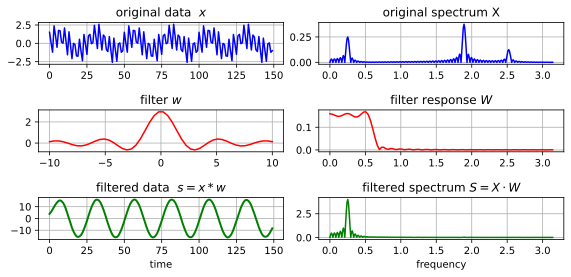

In [17]:
ffig

- Relationships between time and frequency spectrum
  - short-duration signal $\Leftrightarrow$  large frequency spectrum
  - long-duration signal $\Leftrightarrow$ small frequency spectrum
- For filters...
  - short (small) filter only captures short-range correlations (high frequencies).
  - long  (large)  filter can capture long-range correlations (low frequencies).

- Interpretation 2:
  - $\tilde{w}$ is a pattern (template); try to find this pattern.
  - the maximum correlation occurs when pattern $\tilde{w}$ matches the local $x$.
    - for a fixed energy $||x||^2=1$,  $x=\frac{\tilde{w}}{||\tilde{w}||}$ has the maximum correlation with (response to) $\tilde{w}$.

In [18]:
X = trainimg[0].astype('float64')
W = fliplr(flipud(X.astype('float64')))

XX = concatenate(
    [
        concatenate(trainimg[[0,3,6,9]], axis=1),
        concatenate(trainimg[[1,2,5,0]], axis=1),
        concatenate(trainimg[[7,0,4,10]], axis=1)
    ],
    axis=0
).astype('float64')

In [19]:
pfig = plt.figure(figsize=(8,6))
plt.subplot(1,3,1)
plt.imshow(XX, cmap='gray')
plt.title('image $x$')
plt.subplot(1,3,2)
plt.imshow(zeropad2(W, 42, 42, 28, 28), cmap='gray')
plt.title('pattern $\\tilde{w}$')
plt.subplot(1,3,3)
plt.imshow(signal.convolve2d(XX,W,mode='same'), cmap='gray')
plt.title('response s=x*w')
plt.close()



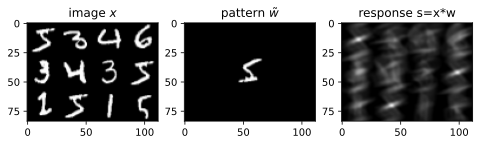

In [20]:
pfig

# Convolution as a layer
- output layer is the convolution of input with filter (kernel) $\mathbf{w}$.
  - $\mathbf{z} = \mathbf{x} * \mathbf{w}$.
- filter $\mathbf{w}$ acts locally on input $\mathbf{x}$.
  - $\mathbf{w}$ also called a **kernel**.
<center><img src="imgs/convlayer.png" width=200></center>

- Equivalent to a linear transformation where $A$ has a particular form.
  - For example, if $\mathbf{w} = [w_1,w_2,w_3]$ and using "same" mode, 
$$\begin{aligned}\mathbf{z} &= \mathbf{x}*\mathbf{w} \\ &= \mathbf{A}^T \mathbf{x} = \begin{bmatrix}w_2 & w_3&0&0&0&0&\cdots\\ w_1 & w_2 & w_3 &  0 & 0 & 0&\cdots\\0 & w_1 & w_2 & w_3 & 0 & 0& \cdots \\ 0 & 0 & w_1 & w_2 & w_3 & 0 & \cdots\\ \cdots & \end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\\\vdots\\x_N\end{bmatrix}\end{aligned}$$
  - Note: $\mathbf{A}$ has size $|\mathbf{x}||\mathbf{z}|$, but only $|\mathbf{w}|$ parameters.

# Translation equivariance
- Shifting $x$ also shifts the response $s$.
- if $s=x*w$,
  - then $s(t-a) = x(t-a)*w(t)$
- We can find the pattern everywhere in $x$ using the same filter. 

In [21]:
X = trainimg[0].astype('float64')
W = fliplr(flipud(X.astype('float64')))

XX = concatenate(
    [
        concatenate(trainimg[[7,7,7,7]], axis=1),
        concatenate(trainimg[[7,0,7,7]], axis=1),
        concatenate(trainimg[[7,7,7,7]], axis=1)
    ],
    axis=0
).astype('float64')


XX2 = concatenate(
    [
        concatenate(trainimg[[7,7,7,7]], axis=1),
        concatenate(trainimg[[7,7,0,7]], axis=1),
        concatenate(trainimg[[7,7,7,7]], axis=1)    
    ],
    axis=0
).astype('float64')


cfig = plt.figure(figsize=(8,4))
plt.subplot(2,3,1)
plt.imshow(XX, cmap='gray')
plt.title('image $x$')
plt.subplot(2,3,2)
plt.imshow(zeropad2(W, 42, 42, 28, 28), cmap='gray')
plt.title('pattern $\\tilde{w}$')
plt.subplot(2,3,3)
plt.imshow(signal.convolve2d(XX,W,mode='same'), cmap='gray')
plt.title('response s=x*w')

plt.subplot(2,3,4)
plt.imshow(XX2, cmap='gray')
plt.subplot(2,3,5)
plt.imshow(zeropad2(W, 42, 42, 28, 28), cmap='gray')
plt.subplot(2,3,6)
plt.imshow(signal.convolve2d(XX2,W,mode='same'), cmap='gray')
plt.close()
        




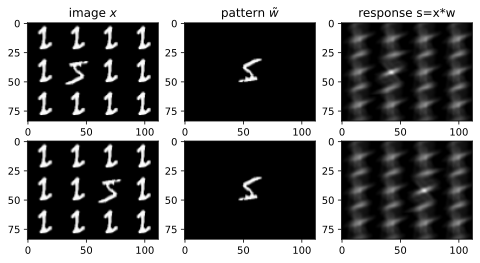

In [22]:
cfig

# Convolutional Neural Network (CNN)
- series of convolutional layers, sub-sampling layers, and MLP classifier.
  - convolutional and subsampling layers extract image features.
  - MLP uses extracted features for classification.

<center><img src="imgs/mylenet.png" width=800></center>

# 2D Convolution
- Use the spatial structure of the image
- 2D convolution filter
  - the weights $\mathbf{W}$ form a 2D filter template
  - filter response: $h = f(\sum_{x,y} W_{x,y} P_{x,y})$
    - $\mathbf{P}$ is an image patch with the same size as $\mathbf{W}$.
- Convolution feature map
  - pass a sliding window over the image, and apply filter to get a _feature map_.
<center><img src="imgs/Convolution_schematic.gif" width=400></center>

- Convolution modes
  - **"valid"** mode - only compute feature where convolution filter has valid image values.
    - size of feature map is reduced.
<center><img src="imgs/conv-valid.gif" width=400></center>

- Convolution modes
  - **"same"** mode - zero-pad the border of the image
    - feature map is the same size as the input image.
<center><img src="imgs/conv-same.gif" width=400></center>
- Usually "same" is better since it looks at structures around border.
  - position information is implicitly encoded in the CNN features based on the zero-padding border.

# 2D Convolutional layer
  - **Input:** HxW image with C channels
    - For example, in the first layer, C=3 for RGB channels.
    - defines a 3D volume: C x H x W (or H x W x C)
  - **Features:** apply F convolution filters to get F feature maps.
    - Each feature map uses a 3D convolution filter (CxKxK) on the input
    - K is the spatial extent of the filter; total FCKK parameters
  - **Activation:** 
    - an activation function can be applied before output
  - **Output:** a feature map with F channels 
    - defines a 3D volume: F x H' x W' 
    - H' and W' depend on various factors.
    
<center><img src="imgs/depthcol2.jpeg" width=300></center>

# Combining Convolutional Layers
- Concatenate several convolutional layers.
  - From layer to layer
    - spatial resolution decreases
    - number of feature maps increases
  - Can extract high-level features in the final layers

- Feature map representation:
<center><img src="imgs/cnn.jpeg" width=500></center>

# Spatial sub-sampling
- reduce the feature map size by subsampling feature maps between convolutional layers
  - *stride* for convolution filter - step size when moving the windows across the image. <center><img src="imgs/conv-stride.gif" width=300></center>      

- Spatial sub-sampling
  - *max-pooling layer* - use the maximum over a pooling window
      - gathers features together, summarizes features in local region.
<center><img src="imgs/conv-pool.png" width=300></center>
      - introduces **translation invariance**
        - it doesn't matter where the maximal feature is located locally, it is passed to the next layer.
        - increases robustness to small changes in configuration of features

# Receptive field size
- Stacking convolutional layers increases the effective size of the pattern filter
  - called **receptive field** - what pixels in the input affect a particular node.
  - larger receptive fields can see larger patterns.
  - Example: 2 convolutional layers
    - $|\mathbf{w_1}| = 5, |\mathbf{w_2}| = 3$,  receptive field size = $|\mathbf{w_1}| + |\mathbf{w_2}| - 1 = 7$
  
<center><img src="imgs/receptivefield.png" width=250></center>

# Advantages of Convolution Layers
- The convolutional filters extract the same features throughout the image.
  - Useful because the object can appear in different locations of the image (global translation equivarience).
- Pooling makes it robust to changes in feature configuration (local translation invariance).
- The number of parameters is small compared to Dense (Fully-connected) layer
  - Example: input is C x H x W, and output is F x H x W
    - Number of MLP parameters: (CHW+1) x (FHW)
    - Number of CNN parameters: F x (CKK+1)

# Fully-connected layers (MLP)
  - after several convolutional layers, input the feature map into an MLP to get the final classification.
  - also called "fully-connected" (FC) layers.
<center><img src="imgs/mylenet.png" width=800></center>

# Example: Object classification CNN
- Each layer shows its feature maps for the example image.
  - early layers extract *low-level* (visual) features
    - e.g., corners, edges
  - middle layers extract *mid-level* (part) features
    - e.g., object parts
  - later layers extract *high-level* (semantic) features.
    - e.g., object
    
<center><img src="imgs/convnet.jpeg" width=600></center>

- The number of feature channels increases with each layer
  - combining low-level parts together to get more higher-level parts
    - e.g., {edges, corners} ->  {wheel, door, window}
  - trading off spatial resolution for semantic specificity
    - e.g., 512x512x3 RGB image -> 8x8x512 semantic features
- the spatial resolution decreases with each layer
  - increase the window size (receptive field) on the object
  - high-level semantic correspond to large regions.

# CNN on MNIST

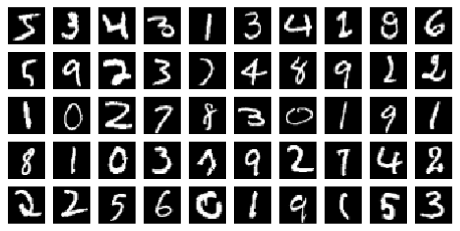

In [23]:
# Example images
plt.figure(figsize=(8,4))
show_imgs(trainimg[0:50])

# 4D tensor format
- There are two common formats for the 4-D tensor:
  - "NCHW" - batch, channel, height, width - called `'channels_first'`
  - "NHWC" - batch, height, width, channel - called `'channels_last'`
- NHWC is required for CPU version of Tensorflow 2.


In [24]:
# use keras backend (K) to force channels-last ordering (for CPU compatability)
K.set_image_data_format('channels_last')

# Example on MNIST
- Pre-processing
  - scale to [0,1]
  - 4-D tensor: (sample, height, width, channel)
    - channel = 1 (grayscale)
  - create training/validation sets

In [25]:
# scale to 0-1
trainI = (trainimg.reshape((6000,28,28,1)) / 255.0)
testI  = (testimg.reshape((10000,28,28,1)) / 255.0)
print(trainI.shape)
print(testI.shape)

(6000, 28, 28, 1)
(10000, 28, 28, 1)


- Generate fixed training and validation sets

In [26]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

validsetI = (validI, validYb)

# Shallow CNN Architecture
- 1 Convolution layer
  - 5x5x1 kernel, 10 features, _stride_ = 2 (step-size between sliding windows)
  - No pooling here since the image input is small (28x28)
  - Input: 28x28x1 (grayscale image) -> Output: 14x14x10
- 1 fully-connected layer (MLP), 50 nodes
  - Input: 14x14x10=1960 -> Output: 50
- Classification output node

In [27]:
# setup early stopping callback function
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto')
callbacks_list = [earlystop]

In [28]:
# initialize random seed
K.clear_session(); random.seed(4487); tf.random.set_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), # channel, kernel size, stride
              activation='relu', padding='same',  # activation, convolution padding
              input_shape=(28,28,1)))
nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00012: early stopping


In [29]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 10)        260       
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                98050     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 98,820
Trainable params: 98,820
Non-trainable params: 0
_________________________________________________________________


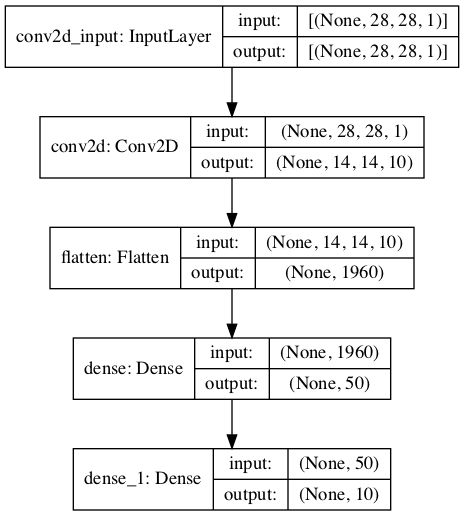

In [30]:
# visualize the network
tf.keras.utils.plot_model(nn, to_file='tmp_model.png', show_shapes=True)

- test results
  - for comparison, the best MLP from Lecture 8 was 0.9499 accuracy
    - 3 layer MLP: (500, 500, 10) with 648,010 parameters

test accuracy: 0.9487


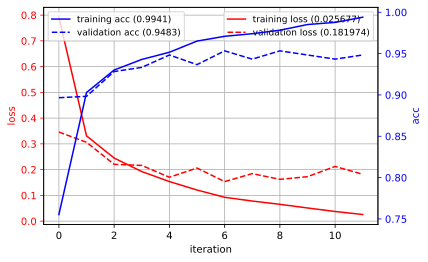

In [31]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

- Visualize the convolutional filters
  - filters are looking for local stroke features
    - corners, edges, lines

(5, 5, 1, 10)


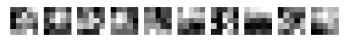

In [32]:
W = nn.get_layer(index=0).get_weights()[0]
print(W.shape)
flist = [squeeze(W[:,:,:,c]) for c in range(10)]
show_imgs(flist)

# Deep CNN Architecture
- 3 Convolutional layers
  - 5x5x1 kernel, stride 2, 10 features (output 14x14x10)
  - 5x5x10 kernel, stride 2, 40 features (output 7x7x40)
  - 5x5x40 kernel, stride 1, 80 features (output 7x7x80)
   - set stride as 1 to avoid reducing the feature map too much)
- 1 fully-connected layer (7x7x80=3920 -> 50)
- Classification output node

In [33]:
# initialize random seed
random.seed(4487); tf.random.set_seed(4487)
# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', 
              padding='same', input_shape=(28,28,1)))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu', padding='same'))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00010: early stopping


In [34]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 10)        260       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 40)          10040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 80)          80080     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                196050    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 286,940
Trainable params: 286,940
Non-trainable params: 0
________________________________________________

test accuracy:  0.9667


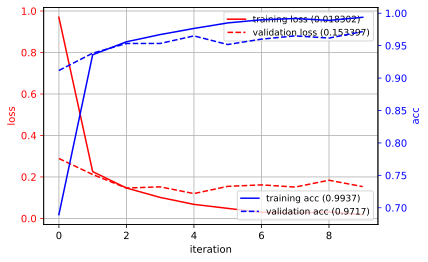

In [35]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy: ", acc)

# Summary
- Convolution operation
  - looks at the local structure of the signal (1D, 2D, 3D, etc).
  - two intepretations: filtering, pattern matching
- Convolutional neural network (CNN)
  - convolutional layer - use convolution instead of dense connections
  - learns to extract image features, and learns classifier.